In [1]:
%%configure -f
{"driverMemory": "6000M"}

In [2]:
import hail as hl
hl.init(sc)

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.1.2-amzn-0
SparkUI available at
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.80-4ccfae1ff293
LOGGING: writing to 

In [3]:
release14_hc_meta_mt_uri =   "SG10K-SV-Release-1.4-HighConfidenceSV-WithMetadata-correctrsid.mt"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
mt = hl.read_matrix_table(release14_hc_meta_mt_uri)
mt.describe()
print("Samples: %d; Variants: %d; Entries: %d" % (mt.count_cols(), mt.count_rows(), mt.entries().count()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'metadata': struct {
        Multiplex_Pool_ID: str, 
        Supplier_ID: str, 
        GIS_Internal_Sample_ID: str, 
        Site_Supplying_Sample: str, 
        Year_Of_Birth: int32, 
        Supplied_Gender: str, 
        Self_Reported_Ethnicity: str, 
        Extraction_Kit: str, 
        Date_Of_DNA_Extraction: str, 
        Plate_Position: str, 
        Plate_Name: str, 
        Version_Of_Consent_Form_Signed: str, 
        Sequencing_Depth: str, 
        NPM_Research_ID_Created_By_Username: str, 
        NPM_Research_ID_Creation_Date: str, 
        Comments_Entered_When_NPM_Research_ID_Created: str, 
        Description_Entered_When_NPM_Research_ID_Created: str, 
        ELM_Project_ID: str, 
        ELM_Project_Title: str, 
        ELM_Project_PI: str, 
        Species_Of_Sample_Sequenced: str, 
        Tehcnique_For_Sequencing: str, 
      

In [5]:
print("N variants - original: %d" % mt.count_rows())
mt = mt.filter_rows(mt.filters.length() == 0)
print("N variants - PASS variants: %d" % mt.count_rows())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

N variants - original: 73035
N variants - PASS variants: 73035

In [6]:
mt.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'metadata': struct {
        Multiplex_Pool_ID: str, 
        Supplier_ID: str, 
        GIS_Internal_Sample_ID: str, 
        Site_Supplying_Sample: str, 
        Year_Of_Birth: int32, 
        Supplied_Gender: str, 
        Self_Reported_Ethnicity: str, 
        Extraction_Kit: str, 
        Date_Of_DNA_Extraction: str, 
        Plate_Position: str, 
        Plate_Name: str, 
        Version_Of_Consent_Form_Signed: str, 
        Sequencing_Depth: str, 
        NPM_Research_ID_Created_By_Username: str, 
        NPM_Research_ID_Creation_Date: str, 
        Comments_Entered_When_NPM_Research_ID_Created: str, 
        Description_Entered_When_NPM_Research_ID_Created: str, 
        ELM_Project_ID: str, 
        ELM_Project_Title: str, 
        ELM_Project_PI: str, 
        Species_Of_Sample_Sequenced: str, 
        Tehcnique_For_Sequencing: str, 
      

In [7]:
## Check the sizes of SV
mt_size = mt.filter_rows(mt.callers_info.SVSIZE >= 10000, keep=True)
mt_size.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(4743, 5487)

In [8]:
svtype_stats = mt_size.aggregate_rows(hl.struct( svtype_stat = hl.agg.counter(mt_size.callers_info.SVTYPE)))
print(svtype_stats.svtype_stat)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

frozendict({'DEL': 2678, 'DUP': 2065})

In [7]:
population_counts = mt.aggregate_cols(hl.agg.counter(mt.metadata.Self_Reported_Ethnicity))
population_counts

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

frozendict({'Chinese': 3088, 'Indian': 1237, 'Malay': 1144, 'Others': 18})

In [8]:
import pandas as pd
from pathlib import Path

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
svtypes = mt.aggregate_rows(hl.agg.counter(mt.callers_info.SVTYPE))
for svtype in svtypes:
    svtype_mt = mt.filter_rows(mt.callers_info.SVTYPE == svtype)
    svtype_mt = hl.sample_qc(svtype_mt)
    svtype_cols = svtype_mt.cols()
    svtype_ethn_sample_qc_df = svtype_cols.select(svtype_cols.metadata.Self_Reported_Ethnicity, svtype_cols.sample_qc).to_pandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2024-05-24 06:49:44 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
2024-05-24 06:49:54 Hail: INFO: Coerced sorted dataset
2024-05-24 06:50:07 Hail: INFO: Coerced sorted dataset
2024-05-24 06:50:18 Hail: INFO: Coerced sorted dataset

In [21]:
# Get SVsize
variants = mt.rows()
svsize_df = variants.select(variants.callers_info.SVTYPE, variants.callers_info.SVSIZE).to_pandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
mt = hl.sample_qc(mt)
mt = hl.variant_qc(mt)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
mt = mt.annotate_rows(
    n_called = mt.variant_qc.n_called,
    n_hom_ref = hl.agg.count_where(mt.GT.is_hom_ref()),
    n_het = hl.agg.count_where(mt.GT.is_het()),
    n_hom_alt = hl.agg.count_where(mt.GT.is_hom_var())
)
mt = mt.annotate_rows(
   n_non_ref = mt.n_hom_alt + mt.n_het 
)
mt.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'metadata': struct {
        Multiplex_Pool_ID: str, 
        Supplier_ID: str, 
        GIS_Internal_Sample_ID: str, 
        Site_Supplying_Sample: str, 
        Year_Of_Birth: int32, 
        Supplied_Gender: str, 
        Self_Reported_Ethnicity: str, 
        Extraction_Kit: str, 
        Date_Of_DNA_Extraction: str, 
        Plate_Position: str, 
        Plate_Name: str, 
        Version_Of_Consent_Form_Signed: str, 
        Sequencing_Depth: str, 
        NPM_Research_ID_Created_By_Username: str, 
        NPM_Research_ID_Creation_Date: str, 
        Comments_Entered_When_NPM_Research_ID_Created: str, 
        Description_Entered_When_NPM_Research_ID_Created: str, 
        ELM_Project_ID: str, 
        ELM_Project_Title: str, 
        ELM_Project_PI: str, 
        Species_Of_Sample_Sequenced: str, 
        Tehcnique_For_Sequencing: str, 
      

In [25]:
variants = mt.rows()
variants = variants.annotate(AF_category = hl.if_else((variants.n_het + variants.n_hom_alt == 1) | ((variants.n_hom_alt == 2) & (variants.n_het == 0)), "singleton", hl.if_else(variants.variant_qc.AF[1] < 0.01, "rare", "common")))
af_category_counts = variants.aggregate(hl.agg.group_by(variants.callers_info.SVTYPE, hl.agg.counter(variants.AF_category)))
af_category_counts_df = pd.DataFrame.from_dict(af_category_counts, orient="index")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
%%sh
pip install boto3

In [28]:
import boto3
import io
import matplotlib.pyplot as plt
import seaborn as sns

def save_fig_to_s3(fig, bucket, key):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='svg', dpi=300)
    img_data.seek(0)

    s3 = boto3.client('s3')
    response = s3.put_object(Bucket=bucket, Key=key, Body=img_data, ContentType='image/svg')
    print(response)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
palette = {
    "population": {
        "CHI": "#D62628",
        "IND": "#9467BD",
        "MAL": "#2EA02B"
    },
    "variantType": {
        "DEL": "#4DBBD5FF",
        "INS": "#DE8F44",
        "DUP": "#00A087FF"
    },
    "extra": [
        "#1E90FF",
        "#FFA500",
        "#EA5F5F"
    ]
}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

# Clear plt
plt.clf()
plt.cla()
fig, ax = plt.subplots(figsize=(10,5))
bins = np.logspace(1, 7, 300)
linewidth = 1.2
for svtype, data in svsize_df.groupby("SVTYPE"):
    hist = np.histogram(data["SVSIZE"], bins=bins)
    ax.plot(hist[1][1:], hist[0], linewidth=linewidth, color=palette["variantType"].get(svtype), label=f"{svtype} ({hist[0].sum():,})")
ax.semilogx()
ax.semilogy()
ax.legend()
ax.set_xlabel("Variant Size (Bp)")
ax.set_ylabel("Number of Variants")
ax.grid(axis="both")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

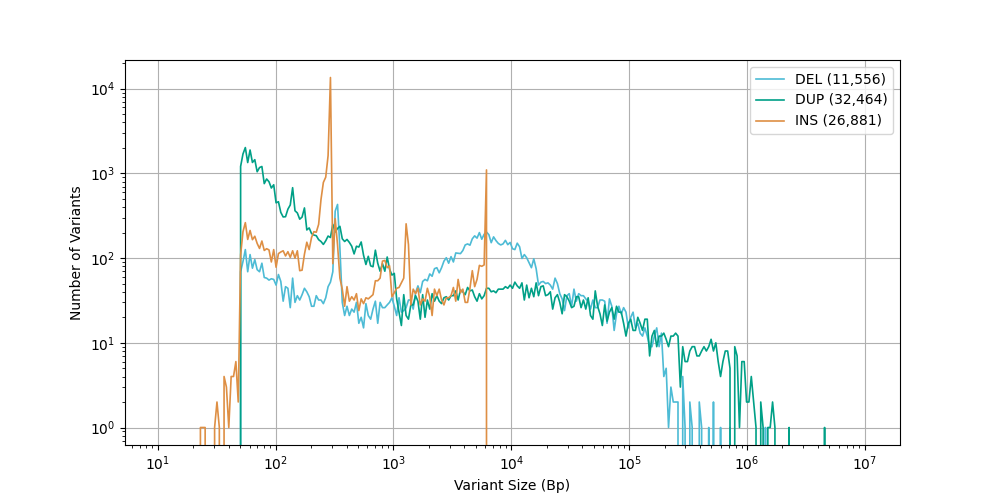

In [31]:
%matplot plt

In [32]:
save_fig_to_s3(plt, "Figures", "Figure2/Fig2b_sizedistribution.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…